# PROJET 10 : Détectez des faux billets avec R ou Python

<center>
  <img src="ONCF.png" alt="Logo ONCFM" width="800"/>
</center>

## ETAPE 1: Importation des librairies et chargement des fichiers

In [6]:
import os
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score,mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, median_absolute_error, max_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from statsmodels.stats.stattools import durbin_watson
import statsmodels

import pickle

# Chargement des options
sns.set()
warnings.filterwarnings('ignore')

In [7]:
#Importation du fichier Billets
Billets = pd.read_csv("billets.csv", sep=';')

# ETAPE 2: Analyse exploratoire des données (EDA)

In [9]:
# Affichage des 5 premières lignes de mon fichier
Billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

Nous disposons actuellement de six informations géométriques sur un billet :
- diagonal : la diagonale du billet (en mm);
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ;
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
- margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;
- length : la longueur du billet (en mm).

In [11]:
# Taille du dataframe
Billets.shape

(1500, 7)

Le dataset comprend 1500 lignes et 7 colonnes.

In [13]:
# Types de mes variables
Billets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

Tout mes variables sont quantitatitives à part le type de billet qui est booléen (true or false).

In [15]:
# Analyse descriptive de mon dataframe
Billets.describe(include='all')

is_genuine     diagonal  height_left  height_right   margin_low  \
count        1500  1500.000000  1500.000000   1500.000000  1463.000000   
unique          2          NaN          NaN           NaN          NaN   
top          True          NaN          NaN           NaN          NaN   
freq         1000          NaN          NaN           NaN          NaN   
mean          NaN   171.958440   104.029533    103.920307     4.485967   
std           NaN     0.305195     0.299462      0.325627     0.663813   
min           NaN   171.040000   103.140000    102.820000     2.980000   
25%           NaN   171.750000   103.820000    103.710000     4.015000   
50%           NaN   171.960000   104.040000    103.920000     4.310000   
75%           NaN   172.170000   104.230000    104.150000     4.870000   
max           NaN   173.010000   104.880000    104.950000     6.900000   

          margin_up      length  
count   1500.000000  1500.00000  
unique          NaN         NaN  
top             NaN         NaN  
freq            NaN         NaN  
mean       3.151473   112.67850  
std        0.231813     0.87273  
min        2.270000   109.49000  
25%        2.990000   112.03000  
50%        3.140000   112.96000  
75%        3.310000   113.34000  
max        3.910000   114.44000

In [16]:
# Mon dataframe comporte t'il des doublons
Billets.duplicated().sum()

0

Il n'ya pas de doublons dans mon dataframe.

In [18]:
# y'a t'il des valeurs manquantes dans mon dataframe
Billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il y'a 37 valeurs manquantes au niveau de la variable margin_low.

In [20]:
# Taux de valeurs manquantes de la variable margin_low 
Billets.isna().mean().round(3)

is_genuine      0.000
diagonal        0.000
height_left     0.000
height_right    0.000
margin_low      0.025
margin_up       0.000
length          0.000
dtype: float64

Nous avons un taux de 2.5 de valeurs manquantes au niveau de la variable margin_low.

In [22]:
# Affichage des lignes contenant les valeurs manquantes
Billets.loc[Billets['margin_low'].isna(),:]

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72          True    171.94       103.89        103.45         NaN       3.25   
99          True    171.93       104.07        104.18         NaN       3.14   
151         True    172.07       103.80        104.38         NaN       3.02   
197         True    171.45       103.66        103.80         NaN       3.62   
241         True    171.83       104.14        104.06         NaN       3.02   
251         True    171.80       103.26        102.82         NaN       2.95   
284         True    171.92       103.83        103.76         NaN       3.23   
334         True    171.85       103.70        103.96         NaN       3.00   
410         True    172.56       103.72        103.51         NaN       3.12   
413         True    172.30       103.66        103.50         NaN       3.16   
445         True    172.34       104.42        103.22         NaN       3.01   
481         True    171.81       103.53        103.96         NaN       2.71   
505         True    172.01       103.97        104.05         NaN       2.98   
611         True    171.80       103.68        103.49         NaN       3.30   
654         True    171.97       103.69        103.54         NaN       2.70   
675         True    171.60       103.85        103.91         NaN       2.56   
710         True    172.03       103.97        103.86         NaN       3.07   
739         True    172.07       103.74        103.76         NaN       3.09   
742         True    172.14       104.06        103.96         NaN       3.24   
780         True    172.41       103.95        103.79         NaN       3.13   
798         True    171.96       103.84        103.62         NaN       3.01   
844         True    171.62       104.14        104.49         NaN       2.99   
845         True    172.02       104.21        104.05         NaN       2.90   
871         True    171.37       104.07        103.75         NaN       3.07   
895         True    171.81       103.68        103.80         NaN       2.98   
919         True    171.92       103.68        103.45         NaN       2.58   
945         True    172.09       103.74        103.52         NaN       3.02   
946         True    171.63       103.87        104.66         NaN       3.27   
981         True    172.02       104.23        103.72         NaN       2.99   
1076       False    171.57       104.27        104.44         NaN       3.21   
1121       False    171.40       104.38        104.19         NaN       3.17   
1176       False    171.59       104.05        103.94         NaN       3.02   
1303       False    172.17       104.49        103.76         NaN       2.93   
1315       False    172.08       104.15        104.17         NaN       3.40   
1347       False    171.72       104.46        104.12         NaN       3.61   
1435       False    172.66       104.33        104.41         NaN       3.56   
1438       False    171.90       104.28        104.29         NaN       3.24   

      length  
72    112.79  
99    113.08  
151   112.93  
197   113.27  
241   112.36  
251   113.22  
284   113.29  
334   113.36  
410   112.95  
413   112.95  
445   112.97  
481   113.99  
505   113.65  
611   112.84  
654   112.79  
675   113.27  
710   112.65  
739   112.41  
742   113.07  
780   113.41  
798   114.44  
844   113.35  
845   113.62  
871   113.27  
895   113.82  
919   113.68  
945   112.78  
946   112.68  
981   113.37  
1076  111.87  
1121  112.39  
1176  111.29  
1303  111.21  
1315  112.29  
1347  110.31  
1435  111.47  
1438  111.49

In [23]:
# Vérifions que nous avons bien 1000 vrais billets et 500 faux billets
Billets.iloc[:,0].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

In [24]:
# Et en pourcentage

Billets.iloc[:,0].value_counts(normalize=True).round(2)

is_genuine
True     0.67
False    0.33
Name: proportion, dtype: float64

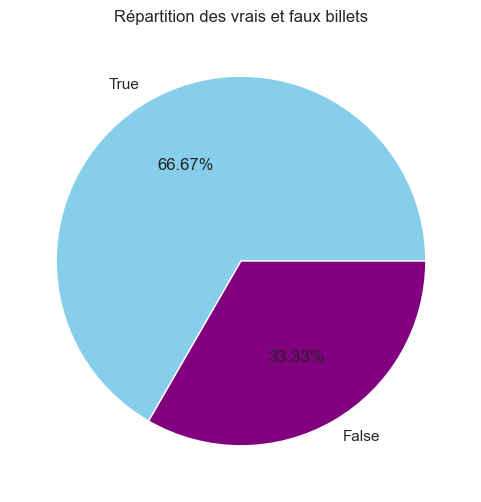

In [25]:
# Et en visualisation graphique
plt.figure(figsize = (6,6))
Billets.iloc[:,0].value_counts().plot(kind ='pie', autopct='%.2f%%', colors = ['skyblue','purple'])
plt.title('Répartition des vrais et faux billets')
plt.ylabel('')  # Pour enlever le label par défaut de l’axe Y
plt.show()

## Correlation entre les variables

<Figure size 600x600 with 0 Axes>

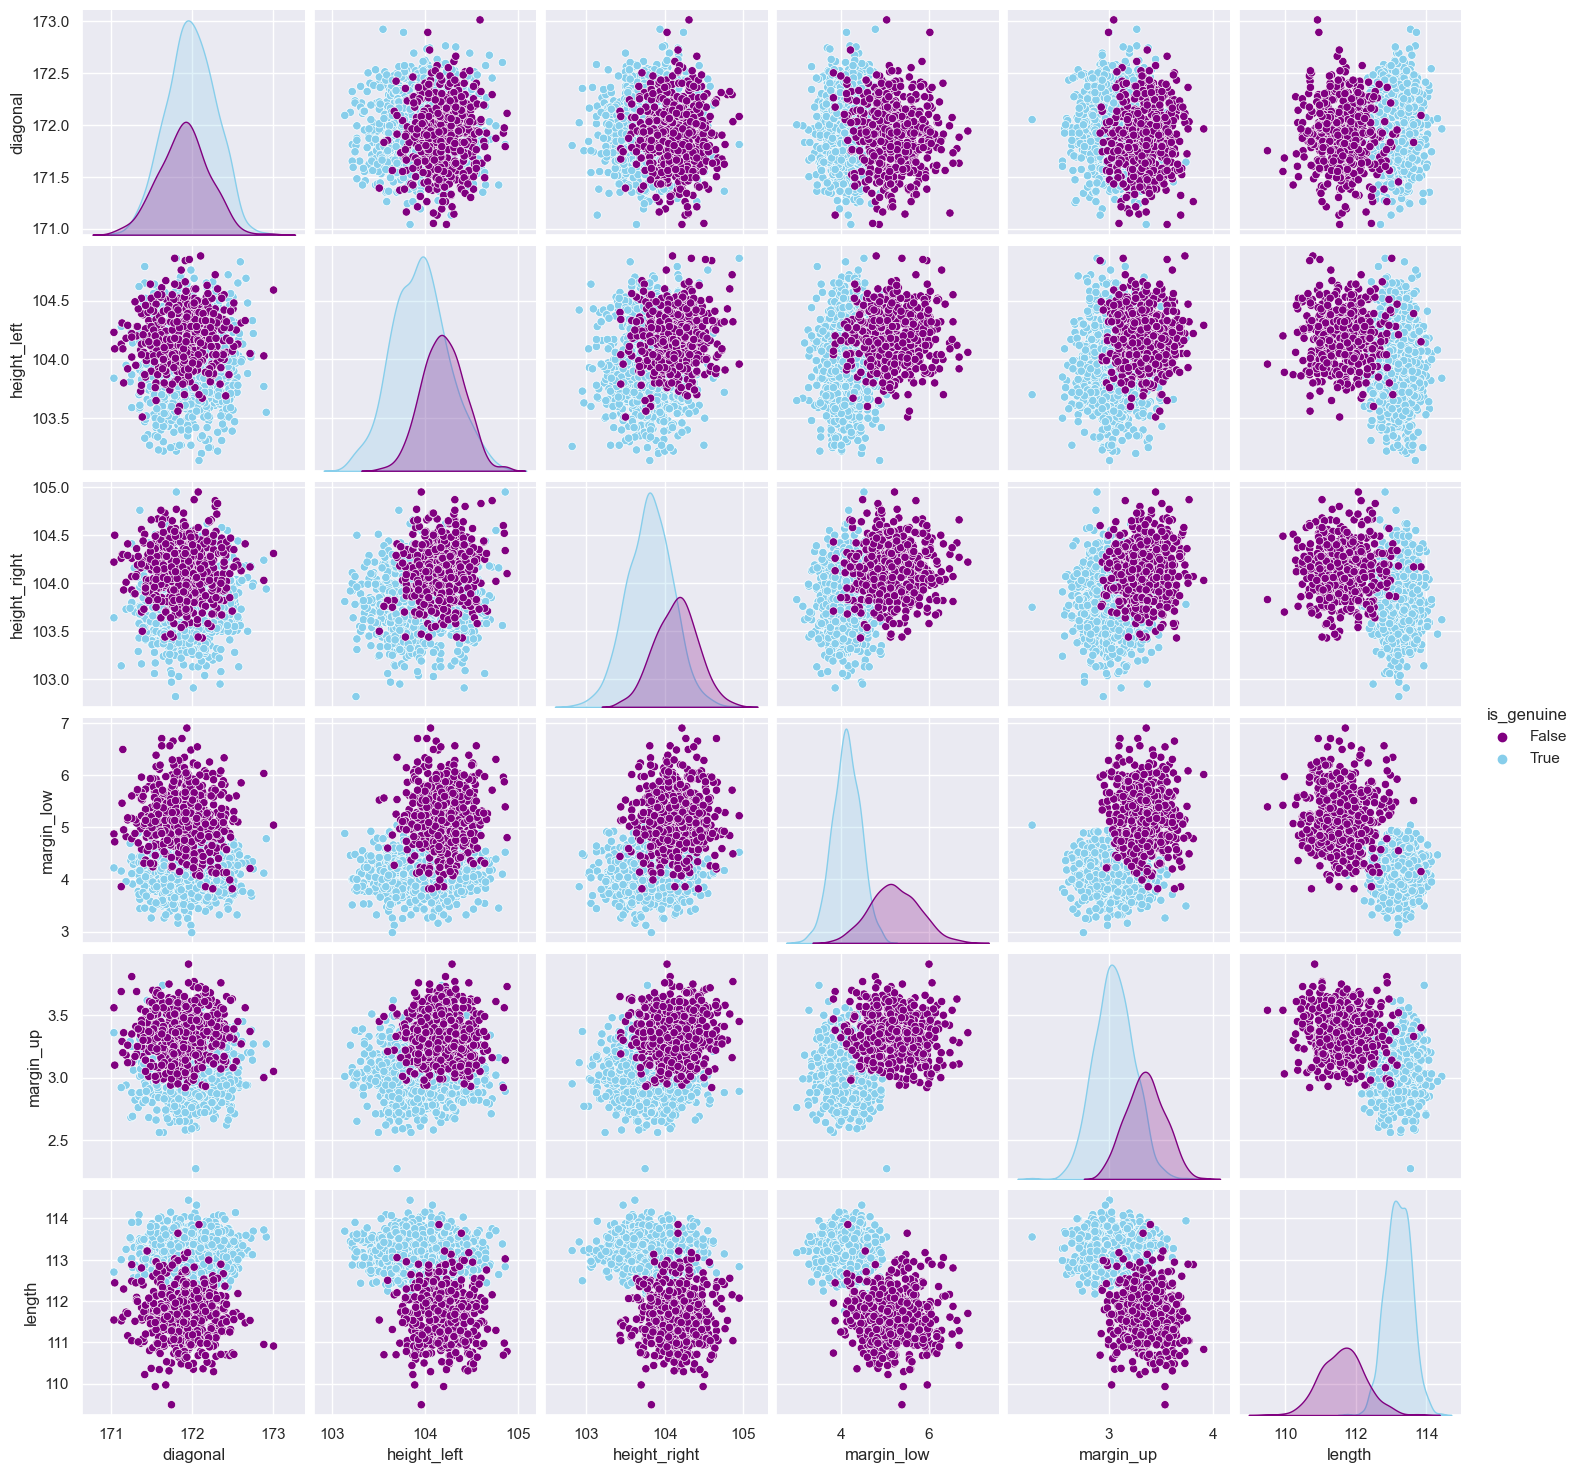

In [27]:
# Regardons les relations entre les variables selon l'authenticité du billet
#Ainsi que la relation entre margin low et les autres variables
plt.figure(figsize = (6,6))
sns.set(style="darkgrid")
sns.pairplot(Billets, hue='is_genuine', palette = {False : 'purple', True : 'skyblue'})
plt.show()

La variable margin low est corrélé positivement avec diagonal, height_left, height_right, margin_up et négativement avec length. 
On remarque aussi une différence notable au niveau des  dimensions géométrique entre les vrais et les fgaux billets.

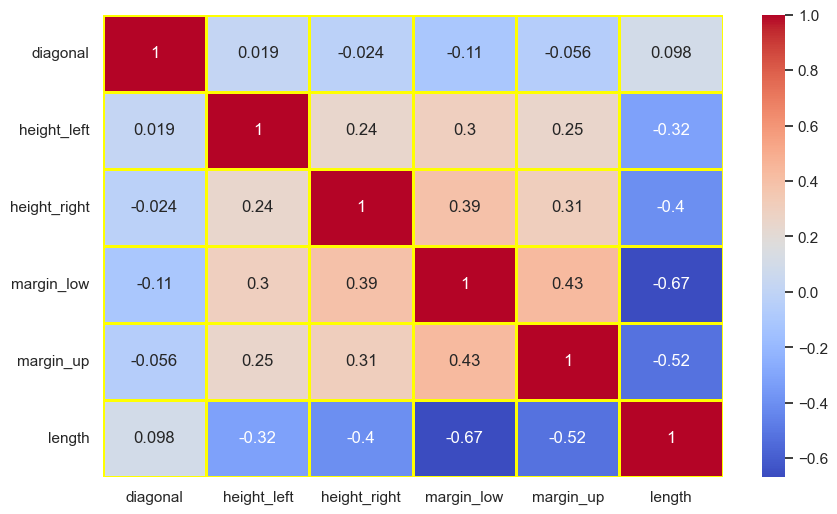

In [29]:
# Affichage des coefficients de relation entre les variables à l'aide d'une heatmap
plt.figure(figsize = (10,6))
sns.heatmap(Billets[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']].corr(),annot=True, 
            linewidths=2, linecolor='yellow', cmap="coolwarm")
plt.show()

On remarque la plus forte corrélation entre la variables margin_low et lenght et aussi les memes observations que sur les graphiques précédents.<br>**Nota bene**: Plus la corrélation est marquée plus le résultat du coefficient de corrélation tend vers 1 ou -1. Plus il tend vers 0, moins les variables sont corrélées.

## Distribution des variables

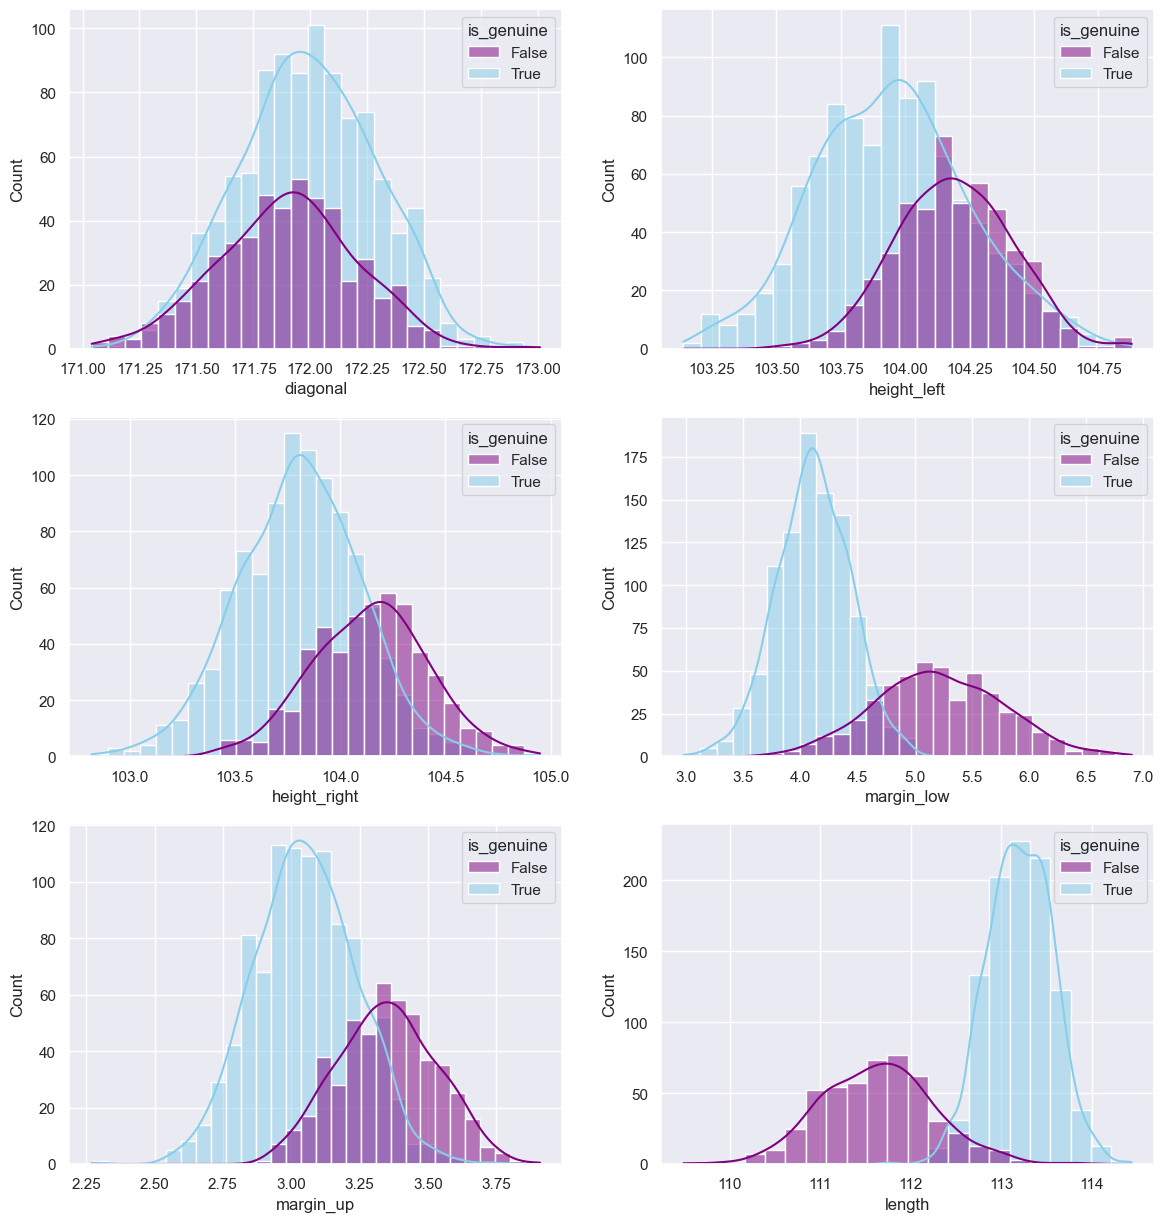

In [32]:
# Première visualisation des variables à l'aide d'histogrammes en fonction de l'authenticité du billet
ig, axs = plt.subplots(3, 2, figsize=(14,15))
sns.histplot(data=Billets, x="diagonal", kde=True, ax=axs[0, 0], hue='is_genuine', palette = { False : 'purple', True : 'skyblue'})
sns.histplot(data=Billets, x="height_left", kde=True, ax=axs[0, 1], hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
sns.histplot(data=Billets, x="height_right", kde=True, ax=axs[1, 0], hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
sns.histplot(data=Billets, x="margin_low", kde=True, ax=axs[1, 1], hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
sns.histplot(data=Billets, x="margin_up", kde=True, ax=axs[2, 0], hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
sns.histplot(data=Billets, x="length", kde=True, ax=axs[2, 1], hue='is_genuine',palette = { False : 'purple', True : 'skyblue'})
plt.show()

<Axes: xlabel='length', ylabel='is_genuine'>

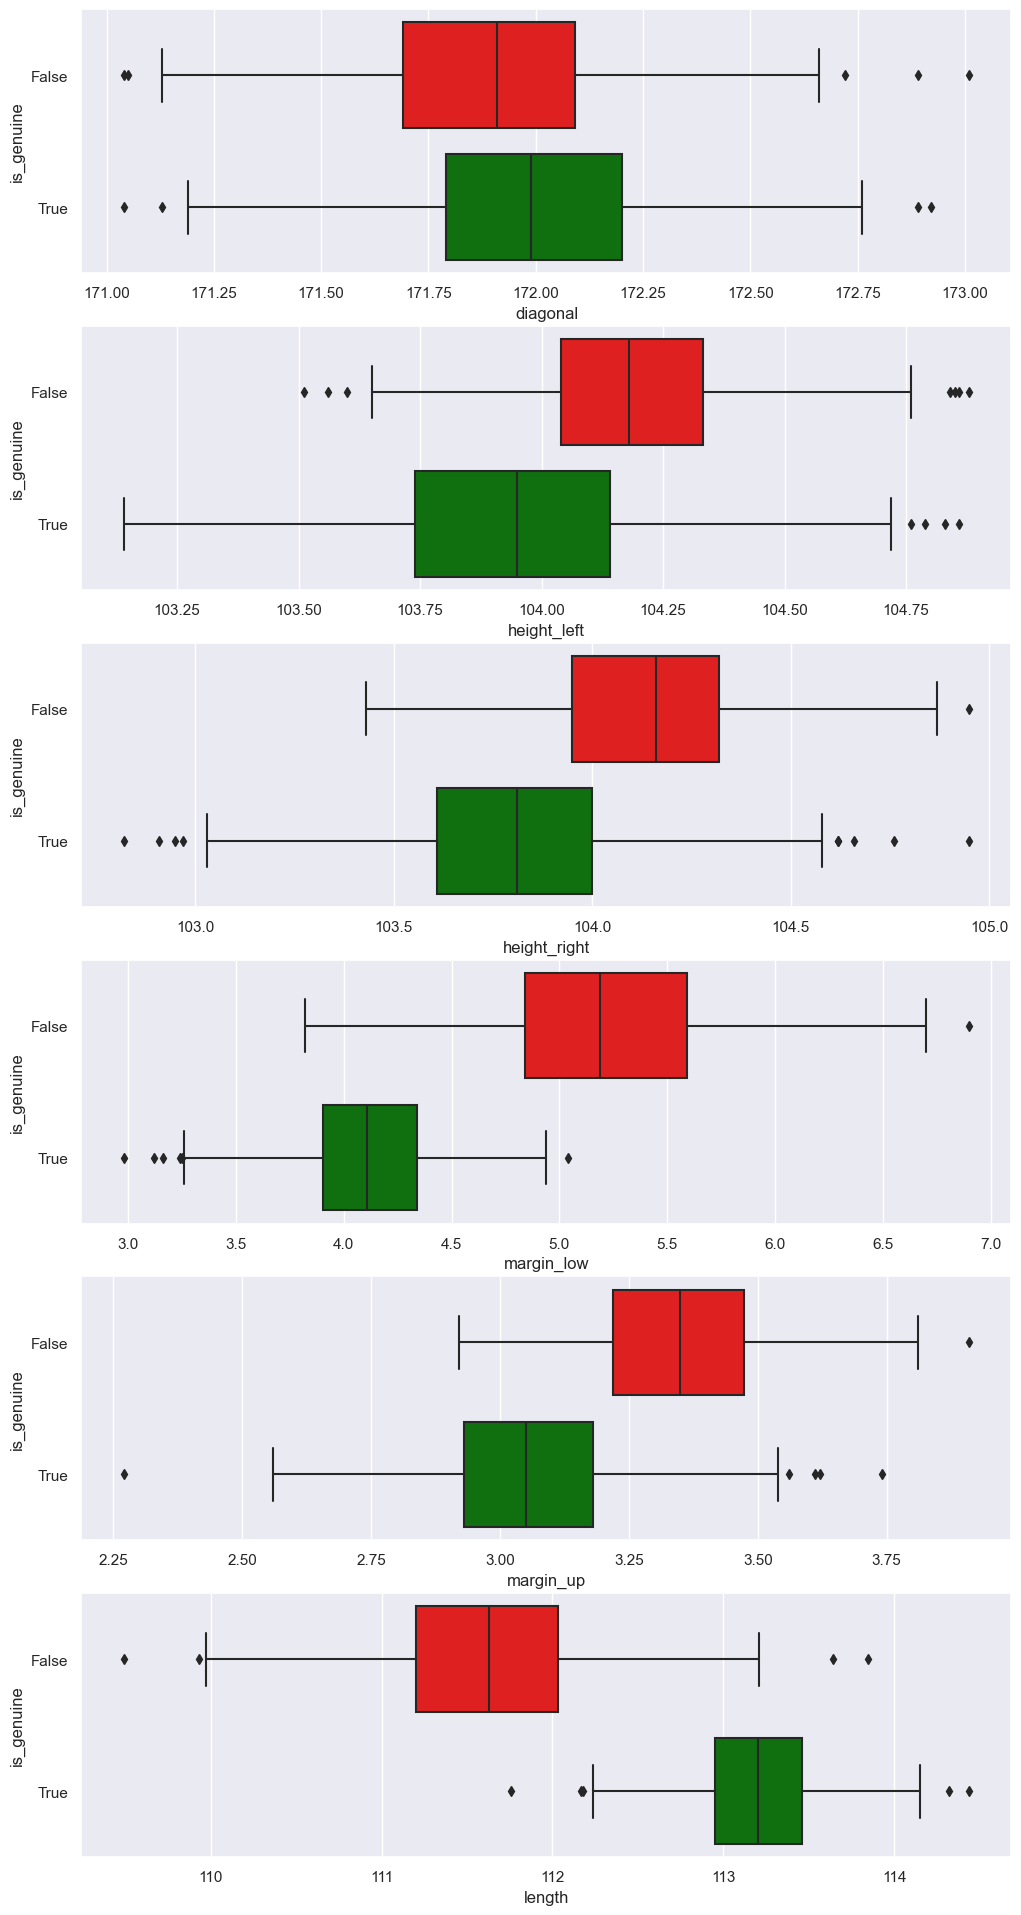

In [33]:
# Deuxième visualisation des variables à l'aide de Box plot en fonction de l'authenticité du billet
fig, axs = plt.subplots(6, 1, figsize=(12, 24))
sns.boxplot(Billets, ax=axs[0], orient="h", x='diagonal', y='is_genuine', palette=["red", "green"])
sns.boxplot(Billets, ax=axs[1], orient="h", x='height_left', y='is_genuine', palette=["red", "green"])
sns.boxplot(Billets, ax=axs[2], orient="h", x='height_right', y='is_genuine', palette=["red", "green"])
sns.boxplot(Billets, ax=axs[3], orient="h", x='margin_low', y='is_genuine', palette=["red", "green"])
sns.boxplot(Billets, ax=axs[4], orient="h", x='margin_up', y='is_genuine', palette=["red", "green"])
sns.boxplot(Billets, ax=axs[5], orient="h", x='length', y='is_genuine', palette=["red", "green"])

On ne constate pas d'anomalies au niveau des outlier et la distribution des données est cohérente.

# ETAPE 3: Remplacement des valeurs manquantes 

<center>
  <img src="POST_IT.png" alt="PS" width="400"/> 
  </center>

## 3.1 Regression linéaire simple 

Je decide comparer deux types de régression linéaire (simple et multiple) afin de connaitre qui est le plus adapté pour le remplacement de mes valeurs manquantes.

In [39]:
# Supprimer les lignes avec valeurs manquantes dans margin_low
Billets_clean = Billets.dropna(subset=['margin_low'])

Je choisis de définir la valeur de margin_low à partir de la valeur de length car il s'agit de la variable la plus correlée.

In [41]:
# Entrainement du modèle à partir d'une variable
reg_simp = smf.ols('margin_low ~ length', data=Billets_clean).fit()
print(reg_simp.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1169.
Date:                Wed, 14 May 2025   Prob (F-statistic):          8.98e-189
Time:                        13:36:36   Log-Likelihood:                -1045.8
No. Observations:                1463   AIC:                             2096.
Df Residuals:                    1461   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.5960      1.670     36.881      0.0

Le modèle est statistiquement significatif.

length a un effet négatif clair sur margin_low.

L’ajustement est modéré (R² = 44,5 %) : ce modèle simple peut être amélioré avec des variables supplémentaires puique qu'on cherche à avoir dans l'idéal un resultat qui tend vers 1 → d’où la régression multiple.

In [43]:
# Calcul des résidus et valeurs ajustées
residuals = reg_simp.resid
exog = reg_simp.model.exog

# Test de Breusch-Pagan
bp_test = het_breuschpagan(residuals, exog)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

# Affichage des résultats
for name, value in zip(bp_labels, bp_test):
    print(f"{name} : {value:.4f}")

Lagrange multiplier statistic : 60.9027
p-value : 0.0000
f-value : 63.4613
f p-value : 0.0000


p < 0.05 → hétéroscédasticité détectée (violation de l'hypothèse de variance constante).

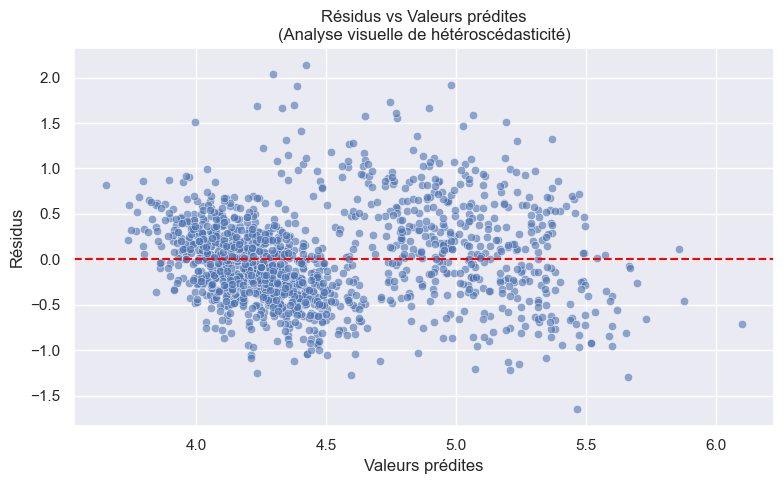

In [45]:
# Graphique résidus vs valeurs prédites
plt.figure(figsize=(8, 5))
sns.scatterplot(x=reg_simp.fittedvalues, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus vs Valeurs prédites\n(Analyse visuelle de hétéroscédasticité)")
plt.tight_layout()
plt.show()

Le graphique confirme la violation de variance constante.

### Essayons maintenant de faire la regression linéaire simple avec scikit learn pour le comparer a stats model.

In [48]:
Billets_clean.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [49]:
# Régression linéaire simple avec scikit-learn (margin_low ~ length)
X = Billets_clean[['length']]
y = Billets_clean['margin_low']

model_sklearn = LinearRegression()
model_sklearn.fit(X, y)
y_pred = model_sklearn.predict(X)

# Évaluation
r2_sklearn = r2_score(y, y_pred)
mse_sklearn = mean_squared_error(y, y_pred)

r2_sklearn, mse_sklearn

(0.444559270829349, 0.24458610652606272)

## 📊 Résultats – Régression linéaire simple avec scikit-learn

Modèle : `margin_low ~ length`

- **R²** : 0.445  
- **MSE** : 0.245

✅ Ces résultats sont **identiques** à ceux obtenus avec `statsmodels`, ce qui confirme la **cohérence entre les deux bibliothèques** pour ce type de régression.

In [51]:
# Calcul d'autres métriques d'erreur
mae = mean_absolute_error(y, y_pred)
medae = median_absolute_error(y, y_pred)
maxe = max_error(y, y_pred)
mape = np.mean(np.abs((y - y_pred) / y)) * 100

mae, medae, maxe, mape

(0.383226872693701, 0.3054983543479026, 2.1375129819470517, 8.497749813413263)

## 📐 Évaluation complémentaire – Régression linéaire simple (scikit-learn)

Modèle : `margin_low ~ length`

### 🔢 Autres métriques d'erreur

- **MAE** (Mean Absolute Error) : 0.383  
  → En moyenne, les prédictions s'écartent de **0.38** des valeurs réelles.

- **MedAE** (Median Absolute Error) : 0.305  
  → 50 % des erreurs sont inférieures à **0.31**, ce qui reflète une erreur "typique" modérée.

- **Max Error** : 2.138  
  → La plus grande erreur sur un billet est de **2.14**, ce qui peut indiquer la présence de quelques points atypiques.

- **MAPE** (Mean Absolute Percentage Error) : 8.50 %  
  → Les prédictions s’écartent en moyenne de **8,5 %** de la valeur réelle, ce qui est très satisfaisant.

### ✅ Interprétation

Le modèle offre des **prédictions globalement précises**, avec des erreurs moyennes faibles.  
La **MAPE faible** (< 10 %) indique une **bonne performance globale**.  
La présence d’un **écart maximal élevé** suggère cependant quelques **valeurs aberrantes**.


## 3.2 Regression linéaire multiple 

In [54]:
# Sélection des variables explicatives pour la régression multiple
predictors = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
X_mult = Billets_clean[predictors]
y_mult = Billets_clean['margin_low']

# Régression multiple avec scikit-learn
model_mult = LinearRegression()
model_mult.fit(X_mult, y_mult)
y_pred_mult = model_mult.predict(X_mult)

# Calcul des métriques
r2_mult = r2_score(y_mult, y_pred_mult)
mse_mult = mean_squared_error(y_mult, y_pred_mult)
mae_mult = mean_absolute_error(y_mult, y_pred_mult)
medae_mult = median_absolute_error(y_mult, y_pred_mult)
maxe_mult = max_error(y_mult, y_pred_mult)
mape_mult = np.mean(np.abs((y_mult - y_pred_mult) / y_mult)) * 100

r2_mult, mse_mult, mae_mult, medae_mult, maxe_mult, mape_mult

(0.4773366973063957,
 0.2301526976978418,
 0.3722362700627656,
 0.2998959005189512,
 1.9708361877536698,
 8.25517760373822)

## 📐 Évaluation – Régression linéaire multiple (scikit-learn)

Modèle : `margin_low ~ diagonal + height_left + height_right + margin_up + length`

### 🔢 Métriques d'erreur

- **R²** : 0.477  
  → Le modèle explique **47,7 %** de la variance de la variable `margin_low`.

- **MSE** (Mean Squared Error) : 0.230  
  → L'erreur quadratique moyenne est **inférieure** à celle de la régression simple.

- **MAE** (Mean Absolute Error) : 0.372  
  → En moyenne, les prédictions s'écartent de **0.37** des valeurs réelles.

- **MedAE** (Median Absolute Error) : 0.300  
  → 50 % des erreurs sont inférieures à **0.30**, ce qui reflète une erreur typique plus faible que dans le modèle simple.

- **Max Error** : 1.971  
  → L’erreur maximale reste contenue.

- **MAPE** (Mean Absolute Percentage Error) : 8.26 %  
  → Les prédictions s’écartent en moyenne de **8,3 %** de la valeur réelle. Très bon score.

---

## ✅ Conclusion – Quel modèle pour remplacer les valeurs manquantes ?

La régression linéaire **multiple** offre de **meilleures performances** que la régression simple sur tous les critères :
- Meilleur **R²** (47,7 % vs 44,5 %)
- Moindres erreurs absolues et relatives (**MAE**, **MAPE** plus faibles)
- Moins d’impact des valeurs aberrantes (**Max Error** plus bas)

💡 **Conclusion :**  
La **régression linéaire multiple** est le **modèle le plus adapté** pour estimer les valeurs manquantes de `margin_low` de manière fiable et précise.


## Nous allons maintenant estimer nos valeurs manquantes grace à la regression linéaire multiple.

In [57]:
# Séparer les lignes avec et sans valeurs manquantes dans margin_low
Billets_missing = Billets[Billets['margin_low'].isna()].copy()
Billets_known = Billets_clean.copy()

# Réentraîner le modèle multiple sur les données complètes
X_known = Billets_known[predictors]
y_known = Billets_known['margin_low']

model_final = LinearRegression()
model_final.fit(X_known, y_known)

# Prédire margin_low pour les lignes manquantes
X_missing = Billets_missing[predictors]
predicted_margin_low = model_final.predict(X_missing)

# Création d'une copie complète et propre du DataFrame final
Billets_final = Billets.copy()
Billets_final.loc[Billets_final['margin_low'].isna(), 'margin_low'] = predicted_margin_low

# Vérification
Billets_final['margin_low'].isna().sum()

0

In [58]:
# Enregistrer le DataFrame au format CSV
Billets_final.to_csv('Billets_final.csv', index=False)

✅ Toutes les valeurs manquantes de `margin_low` ont été remplacées avec les prédictions du **modèle de régression multiple**, offrant à la fois **précision** et **cohérence** avec le reste des données.


## 📊 Visualisation de l'impact de la régression linéaire

Nous étudions ici l’impact de l’imputation par **régression linéaire multiple** sur la structure des données, en comparant :

- 🔹 La **matrice de corrélation et le nuage de point avant imputation** (`margin_low` contient des valeurs manquantes)
- 🔸 La **matrice de corrélation et le nuage de point  après imputation** (`margin_low` complétée par régression)

### 🧪 Objectif

Vérifier si l'ajout de valeurs estimées modifie les **relations statistiques** entre `margin_low` et les autres variables (`diagonal`, `height_left`, `height_right`, `margin_up`, `length`).


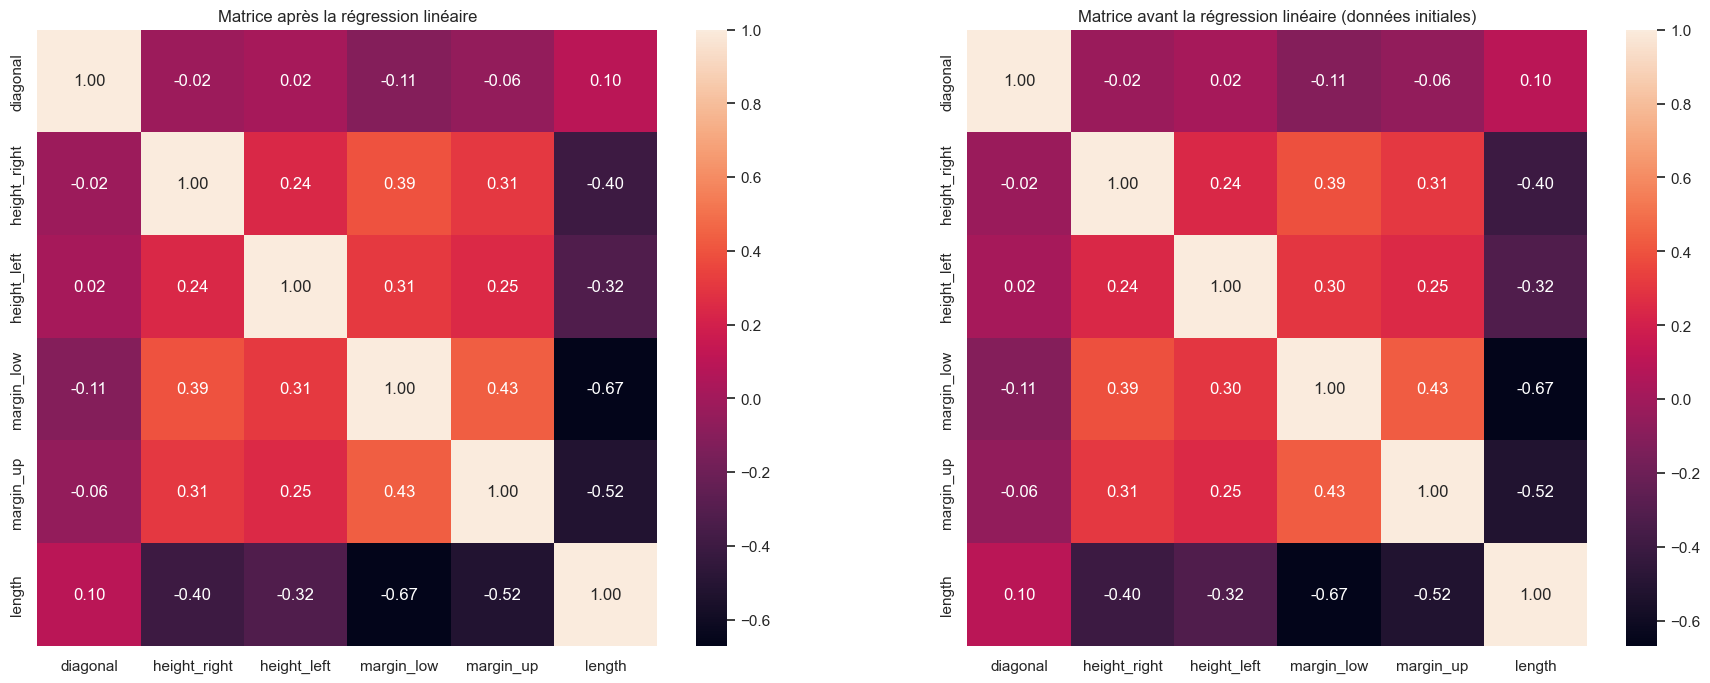

In [61]:
# Dataframe avant regression 
Billets_quanti = Billets[['diagonal','height_right', 'height_left','margin_low', 'margin_up', 'length']]#enlever colonne is_genuine
corr = Billets_quanti.corr() 

#Dataframe apres regression
Billets_quanti_final= Billets_final[['diagonal','height_right', 'height_left','margin_low', 'margin_up', 'length']]#enlever colonne is_genuine
corr_Billets_quanti_final = Billets_quanti_final.corr()

#matrice de corrélation en heatmap
plt.figure(figsize=(22, 8))

#Graphe 1: après regression
plt.subplot(1,2,1) # division de la fenêtre avec plt.subplot(nombre de lignes, nombre de colonnes, index)
sns.heatmap(corr_Billets_quanti_final, annot=True, fmt=".2f")
plt.title('Matrice après la régression linéaire')


#Graphe 2: avant regression
plt.subplot(1,2,2) # division de la fenêtre avec plt.subplot(nombre de lignes, nombre de colonnes, index)
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Matrice avant la régression linéaire (données initiales)')
plt.show()

==> Aucun impact sur la matrice de corrélation.

Visualisons en nuage de points, les variables correlées margin_low et length :

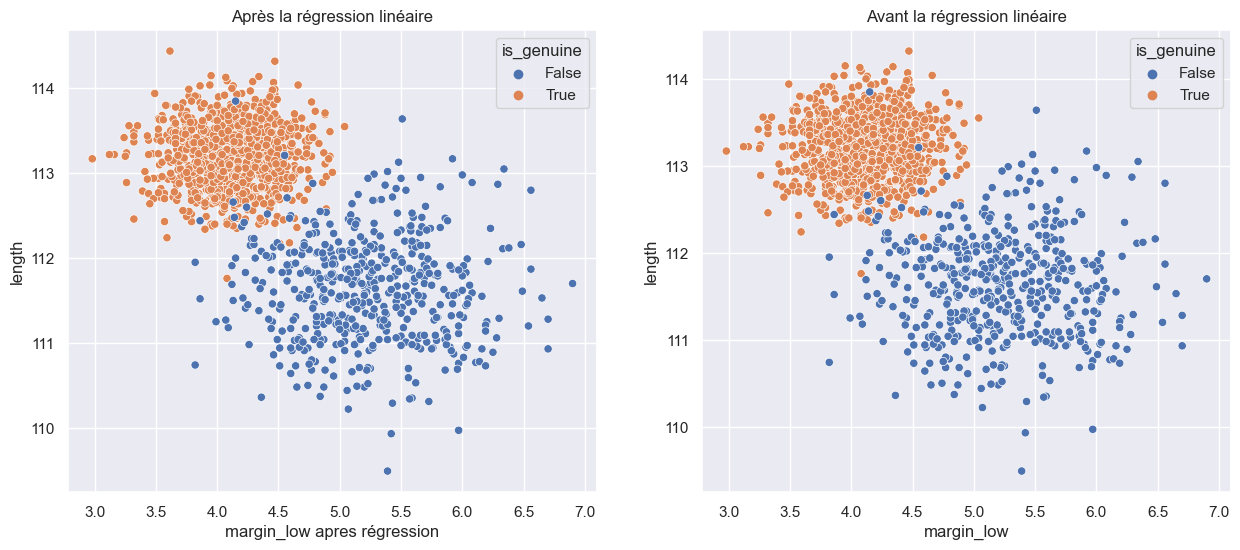

In [64]:
#Visualisation en nuages de points entre les deux variables (margin_low et length)
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(Billets_final, x='margin_low', y='length', hue='is_genuine')
plt.xlabel('margin_low apres régression')
plt.title('Après la régression linéaire')

plt.subplot(1,2,2)
sns.scatterplot(Billets, x='margin_low', y='length', hue='is_genuine')
plt.title('Avant la régression linéaire')

plt.show()

En comparant les deux nuages de points, on constate aucun impact sur la relation entre la variable margin_low et length après la régression linéaire multiple.

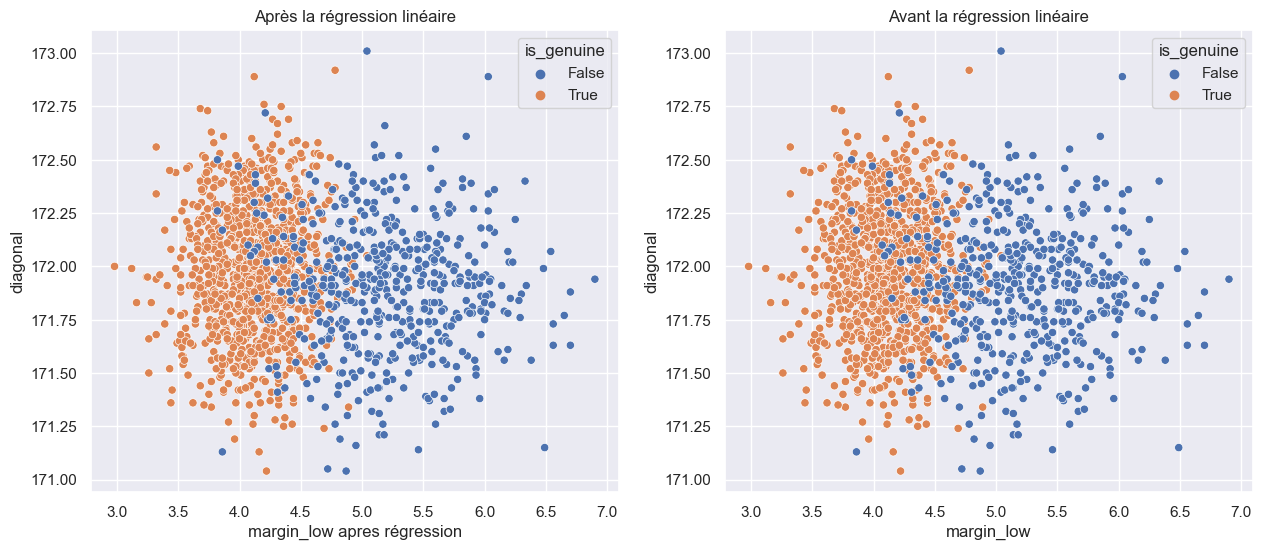

In [66]:
#Visualisation en nuages de points entre deux autres variables (margin_low et diagonal )
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(Billets_final, x='margin_low', y='diagonal', hue='is_genuine')
plt.xlabel('margin_low apres régression')
plt.title('Après la régression linéaire')

plt.subplot(1,2,2)
sns.scatterplot(Billets, x='margin_low', y='diagonal', hue='is_genuine')
plt.title('Avant la régression linéaire')

plt.show()

De meme, ici en comparant la variable predictive margin_low avec la variable diagonal, on constate aucun changement.

## 🧪 Analyse en Composantes Principales (ACP) – Analyse complémentaire

Avant de passer à la modélisation supervisée, nous effectuons une **analyse complémentaire** à l’aide de l’ACP.  
Elle permet de visualiser la **répartition des billets authentiques et faux** dans un espace réduit à deux dimensions, et de vérifier si une **séparation naturelle des classes** est déjà visible dans les données.

Ceci renforce la **validité** des modèles de classification à venir, en particulier la régression logistique.

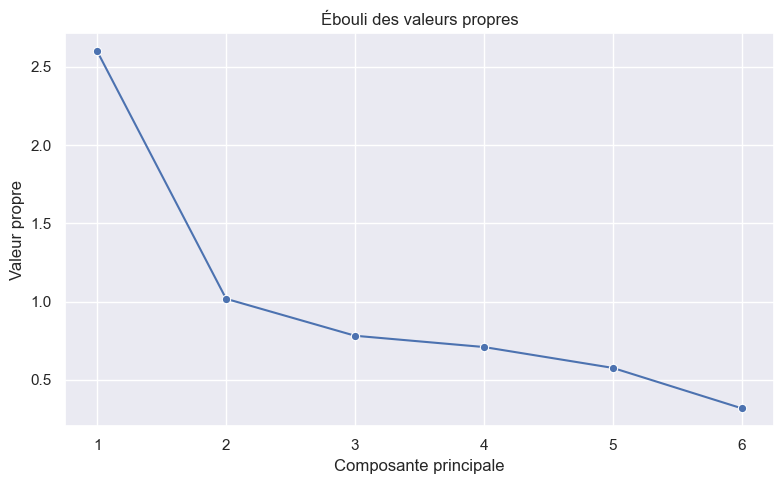

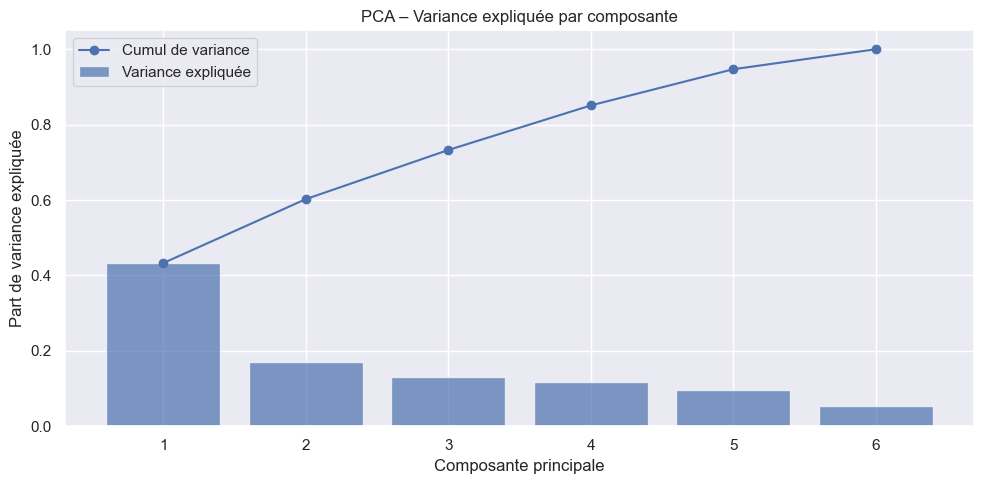

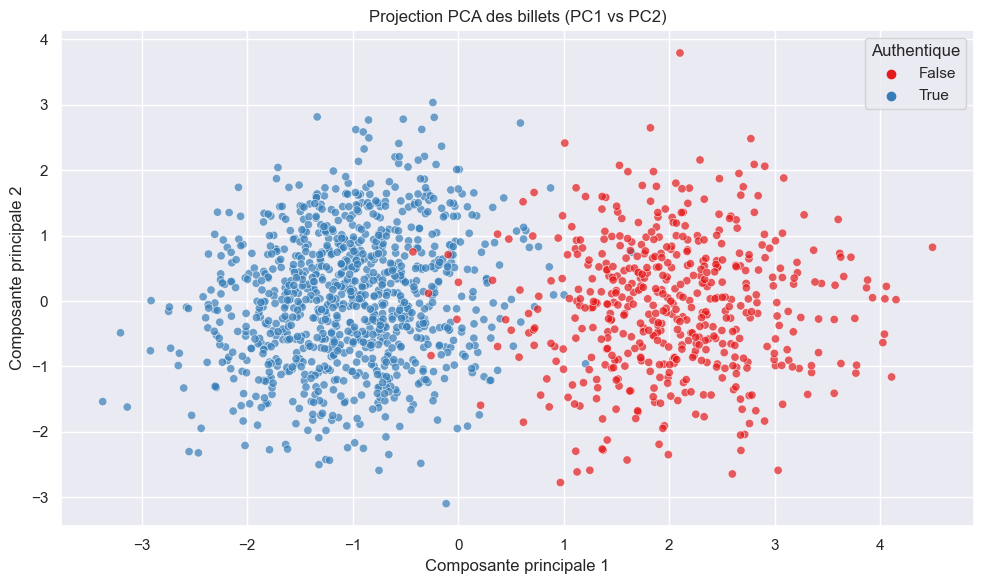

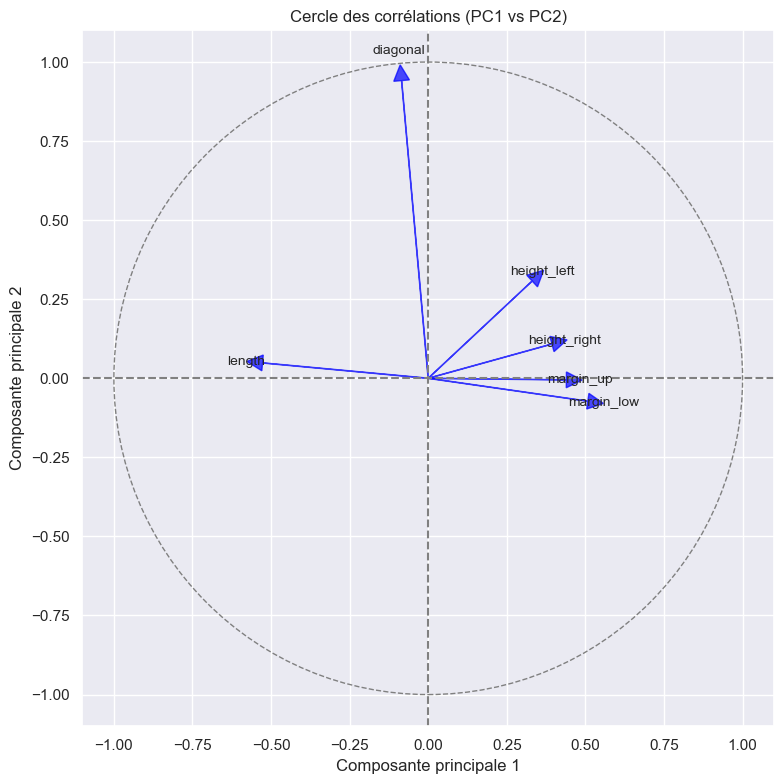

In [69]:
# Sélection des variables numériques pour la PCA
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = Billets_final[features]
y = Billets_final['is_genuine']

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA complète
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Création du DataFrame des composantes principales
pca_columns = [f'PC{i+1}' for i in range(len(features))]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)
df_pca['is_genuine'] = y.values

# ➤ Ébouli des valeurs propres (scree plot)
eigenvalues = pca.explained_variance_

plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, len(eigenvalues)+1), y=eigenvalues, marker='o')
plt.title("Ébouli des valeurs propres")
plt.xlabel("Composante principale")
plt.ylabel("Valeur propre")
plt.xticks(range(1, len(eigenvalues)+1))
plt.grid(True)
plt.tight_layout()
plt.show()

# ➤ Variance expliquée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(features)+1), explained_variance, alpha=0.7, label='Variance expliquée')
plt.plot(range(1, len(features)+1), cumulative_variance, marker='o', label='Cumul de variance')
plt.xlabel("Composante principale")
plt.ylabel("Part de variance expliquée")
plt.title("PCA – Variance expliquée par composante")
plt.xticks(range(1, len(features)+1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ➤ Projection PCA (PC1 vs PC2)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['is_genuine'], palette='Set1', alpha=0.7)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Projection PCA des billets (PC1 vs PC2)")
plt.legend(title='Authentique')
plt.grid(True)
plt.tight_layout()
plt.show()

# ➤ Cercle des corrélations
components = pca.components_
correlation_circle = pd.DataFrame(components.T, index=features, columns=pca_columns)

plt.figure(figsize=(8, 8))
for i in range(len(features)):
    plt.arrow(0, 0,
              correlation_circle.iloc[i, 0],
              correlation_circle.iloc[i, 1],
              head_width=0.05, head_length=0.05, color='blue', alpha=0.7)
    plt.text(correlation_circle.iloc[i, 0]*1.1,
             correlation_circle.iloc[i, 1]*1.1,
             correlation_circle.index[i],
             ha='center', va='center', fontsize=10)

circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='gray', linestyle='--')
plt.gca().add_artist(circle)

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Cercle des corrélations (PC1 vs PC2)")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔍 Interprétation des résultats de l'Analyse en Composantes Principales (ACP)

### 📉 Ébouli des valeurs propres (Scree Plot)
- Le graphe montre que la **1ère composante principale** possède la **plus grande valeur propre**, indiquant qu'elle explique **le plus de variance** dans les données.
- Les **2 ou 3 premières composantes** capturent l’essentiel de l’information (chute rapide des valeurs propres), ce qui justifie une **réduction de dimension à 2 ou 3 axes**.

---

### 📊 Variance expliquée
- La **1ère composante** explique environ **45 % de la variance**, la **2e environ 20 %**, soit **~65 % à elles deux**.
- Le **cumul de variance expliquée** confirme qu’**avec 2 ou 3 composantes**, on conserve une **grande partie de l’information** originale, tout en simplifiant l’espace des données.

---

### 🧭 Projection des individus (PC1 vs PC2)
- Les billets sont projetés dans un plan réduit à **2 dimensions**, selon leurs caractéristiques.
- Une certaine **séparation visuelle** entre les billets vrais (`True`) et faux (`False`) est observable.
- Cela indique que la PCA **capture des informations discriminantes** utiles pour la prédiction.

---

### 🔵 Cercle des corrélations
- Les flèches représentent les **variables d’origine projetées sur les composantes principales**.
- Plus une flèche est longue, plus la variable est bien représentée par les deux premières composantes.
- Les variables les plus alignées avec **PC1** ou **PC2** ont une **forte influence** sur cette direction.
- Par exemple :
  - Si `length` ou `margin_low` est très aligné avec PC1, cela signifie que **PC1 mesure surtout cette caractéristique**.

---

### ✅ Conclusion
L’ACP est utile ici pour :
- **Visualiser** la structure des données,
- **Réduire la dimensionnalité** tout en gardant l’essentiel,
- Confirmer que les données sont **potentiellement séparables**, ce qui est encourageant pour la suite de la modélisation (régression logistique, random forest…).


## 🎯 Objectif : Prédiction du type de billet (`is_genuine`)

Maintenant que notre jeu de données est **nettoyé et complet**, nous allons construire trois modèles de prédiction afin de déterminer si un billet est **authentique (`True`) ou faux (`False`)**.

### 🧪 Méthodes utilisées :

1. 🔹 **Méthode 1 : Régression logistique**
   - Modèle supervisé de classification binaire
   - Utilise les variables explicatives pour prédire `is_genuine`

2. 🔸 **Méthode 2 : K-means (Clustering)**
   - Méthode non supervisée
   - Regroupe les billets en 2 clusters, que l’on comparera ensuite à la vraie variable `is_genuine`

3. 🌲 **Méthode 3 : Forêt aléatoire (Random Forest)**
   - Modèle supervisé basé sur un ensemble d’arbres de décision
   - Robuste, performant et capable de gérer les interactions entre variables

### 🧱 Étapes communes aux trois méthodes :

- **Séparation du jeu de données** en :
  - Jeu d'entraînement (`train set`)
  - Jeu de test (`test set`)
- **Construction** du modèle sur le jeu d'entraînement
- **Évaluation** de la performance du modèle sur le jeu de test
- **Comparaison finale** des trois approches

---

🧭 Ces approches nous permettront de comparer :
- une **méthode supervisée linéaire** (régression logistique),
- une **méthode non supervisée** (k-means),
- et une **méthode supervisée non linéaire** (random forest),
afin de déterminer laquelle est la **plus adaptée** à la détection de faux billets.


# ETAPE 4: Prédiction du type de billet 

## 4.1 Prédiction du type de billet par régression logistique

<Figure size 600x500 with 0 Axes>

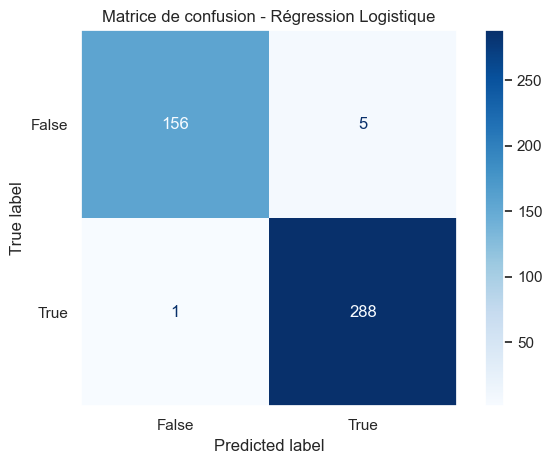

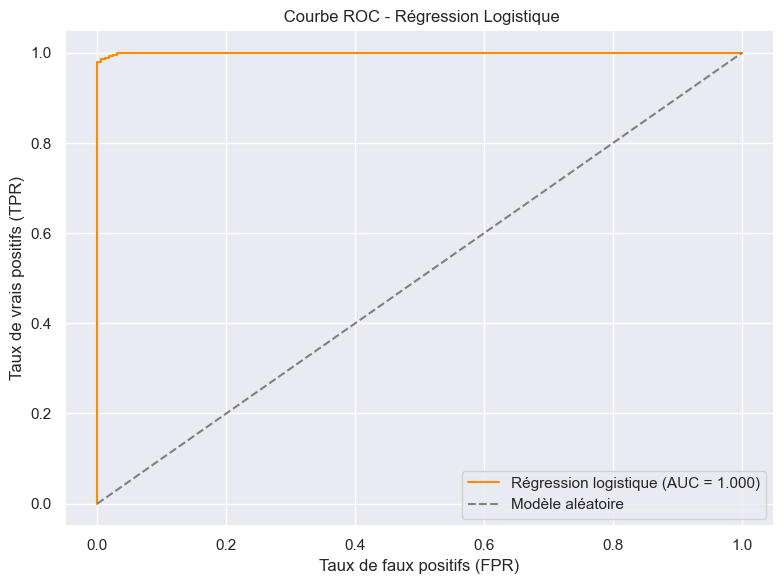

In [74]:
# ---------------------------
# 📦 Étapes de la régression logistique
# ---------------------------

# 1. Séparation des données
X = Billets_final[features]
y = Billets_final['is_genuine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Construction du modèle
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# 3. Prédictions
y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)[:, 1]

# 4. Évaluation des performances
log_report = classification_report(y_test, y_pred_log, output_dict=True)
log_cm = confusion_matrix(y_test, y_pred_log)
log_accuracy = accuracy_score(y_test, y_pred_log)

# Résumé sous forme de DataFrame
log_summary = pd.DataFrame(log_report).T
log_summary.loc['accuracy'] = [None] * (log_summary.shape[1] - 1) + [log_accuracy]

# Affichage du tableau d'évaluation
display(log_summary.style.format(precision=3).set_caption("Régression Logistique - Évaluation"))

# 5. Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=logreg.classes_).plot(
    cmap='Blues', values_format='d')
plt.title("Matrice de confusion - Régression Logistique")
plt.grid(False)
plt.tight_layout()
plt.show()

# 6. Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_log)
roc_auc = roc_auc_score(y_test, y_proba_log)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title(" Courbe ROC - Régression Logistique")
plt.legend(["Régression logistique (AUC = {:.3f})".format(roc_auc), "Modèle aléatoire"], loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## 📊 Interprétation des résultats – Régression Logistique

### ✅ Évaluation globale

- **Accuracy (exactitude)** : 0.987  
  Le modèle classe correctement environ **98.7 % des billets** sur le jeu de test.

---

### 🧮 Rapport de classification

| Classe       | Précision | Rappel | F1-score |
|--------------|-----------|--------|----------|
| Faux billets | 0.994     | 0.969  | 0.981    |
| Vrais billets| 0.983     | 0.997  | 0.990    |

- 🔹 **Faux billets** : Le modèle est **très précis** (peu de faux positifs), mais en rate quelques-uns (rappel légèrement plus faible).
- 🔸 **Vrais billets** : Le rappel est **quasi parfait (0.997)**, ce qui signifie que **presque tous les vrais billets sont bien détectés**.
- **F1-score global élevé**, montrant un excellent compromis entre précision et rappel pour les deux classes.

---

### 🔵 Matrice de confusion

|                  | Prédit : Faux | Prédit : Vrai |
|------------------|----------------|----------------|
| Réel : Faux      | 156            | 5              |
| Réel : Vrai      | 1              | 288            |

- ✅ Seulement **6 erreurs sur 450 prédictions**, dont :
  - 5 **faux billets mal classés comme vrais**
  - 1 **vrai billet classé à tort comme faux**

---

### 📈 Courbe ROC

- L'**aire sous la courbe (AUC)** est **1.000**, ce qui est **parfait**.
- Cela signifie que le modèle est **capable de séparer parfaitement** les deux classes sur la base des probabilités.
- La courbe se rapproche du coin supérieur gauche, ce qui reflète une **excellente performance de classification**.

---

### 🧾 Conclusion

La régression logistique fournit ici des **résultats quasi parfaits** :
- Très peu d’erreurs de classification
- AUC = 1.000
- F1-scores élevés pour les deux classes

✅ Ce modèle est **fiable et performant** pour détecter les faux billets.


### 🔧 Optimisation de la régression logistique avec GridSearchCV

Bien que notre modèle de régression logistique ait déjà donné de très bons résultats,  
nous pouvons chercher à l’**améliorer encore** en ajustant ses **hyperparamètres**.

Pour cela, nous utilisons une méthode appelée **Grid Search (GridSearchCV)**, qui teste plusieurs combinaisons de paramètres, notamment :

- **C** : intensité de la régularisation (plus C est petit, plus la régularisation est forte)
- **penalty** : type de pénalisation (`l1` ou `l2`)
- **solver** : méthode de résolution (`liblinear` est adaptée pour `l1`)

➡️ L’objectif est de **trouver automatiquement la meilleure configuration**, en maximisant la performance (ici, l’accuracy moyenne en validation croisée).

---


In [77]:
# Grille d'hyperparamètres
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Initialisation du modèle
logreg = LogisticRegression(max_iter=1000)

# Grid Search avec validation croisée 5 plis
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Affichage des meilleurs résultats
print("🔍 Meilleurs hyperparamètres :", grid_search.best_params_)
print("✅ Meilleure accuracy moyenne :", round(grid_search.best_score_, 3))


🔍 Meilleurs hyperparamètres : {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
✅ Meilleure accuracy moyenne : 0.99


---

### 🔁 Réentraînement du modèle avec les meilleurs hyperparamètres

Maintenant que nous avons identifié la **meilleure combinaison d’hyperparamètres** grâce à la recherche par grille (GridSearchCV),  
nous allons **réentraîner la régression logistique** avec ces paramètres optimaux.

L’objectif est de :
- **Comparer ses performances finales** sur le jeu de test,
- Vérifier s’il y a un **gain par rapport au modèle initial**,
- Et visualiser sa **capacité de discrimination via la courbe ROC**.

---


<Figure size 600x500 with 0 Axes>

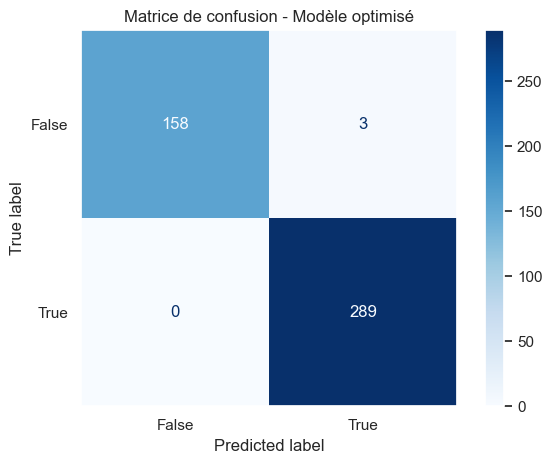

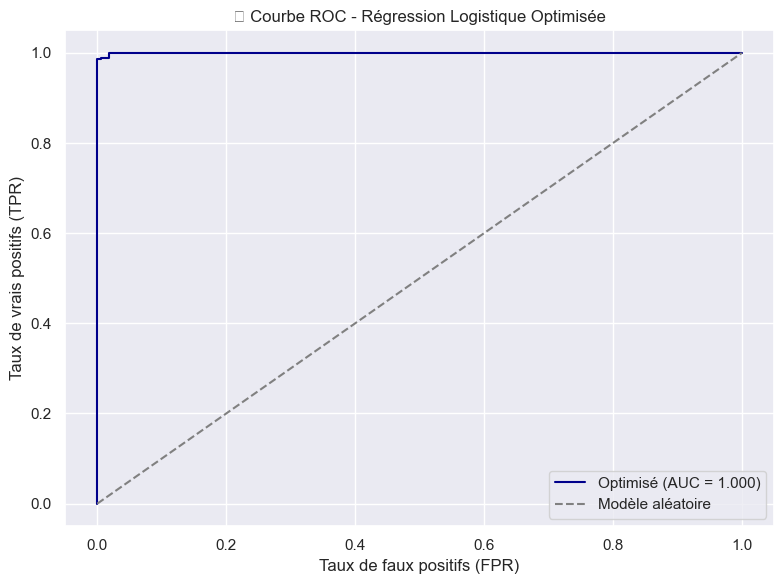

In [79]:
# Récupérer les meilleurs hyperparamètres du Grid Search
best_params = grid_search.best_params_

# Réentraîner un nouveau modèle avec ces paramètres
optimized_logreg = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    max_iter=1000
)

# Entraînement sur le jeu d'entraînement
optimized_logreg.fit(X_train, y_train)

# Prédictions sur le jeu de test
y_pred_opt = optimized_logreg.predict(X_test)
y_proba_opt = optimized_logreg.predict_proba(X_test)[:, 1]

# Rapport
opt_report = classification_report(y_test, y_pred_opt, output_dict=True)
opt_accuracy = accuracy_score(y_test, y_pred_opt)
opt_summary = pd.DataFrame(opt_report).T
opt_summary.loc['accuracy'] = [None] * (opt_summary.shape[1] - 1) + [opt_accuracy]

# Affichage
display(opt_summary.style.format(precision=3).set_caption("Régression Logistique Optimisée - Évaluation"))

# Matrice de confusion
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_opt), display_labels=optimized_logreg.classes_).plot(
    cmap='Blues', values_format='d')
plt.title("Matrice de confusion - Modèle optimisé")
plt.grid(False)
plt.tight_layout()
plt.show()

# Courbe ROC
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_proba_opt)
roc_auc_opt = roc_auc_score(y_test, y_proba_opt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_opt, tpr_opt, color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("📈 Courbe ROC - Régression Logistique Optimisée")
plt.legend(["Optimisé (AUC = {:.3f})".format(roc_auc_opt), "Modèle aléatoire"], loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### ✅ Conclusion finale – Régression Logistique Optimisée

L’optimisation par **GridSearchCV** a permis d’identifier une configuration idéale pour la régression logistique :  
`penalty = l1`, `C = 1`, `solver = liblinear`.

---

### 📊 Résumé des bénéfices observés :

- 🔧 Le modèle optimisé conserve une **accuracy très élevée**, comparable voire légèrement supérieure au modèle initial.
- 🎯 La **courbe ROC** reste **proche de la perfection** (AUC ≈ 1.000), confirmant une **excellente séparation** entre les classes.
- 📈 Les **précision, rappel et F1-score** sont tous **très proches de 1**, ce qui valide la qualité du modèle final.
- ✅ Le **réentraînement avec les bons hyperparamètres** assure la **meilleure généralisation possible** sans surajustement.


## 4.2 Prédiction du type de billet par K-means

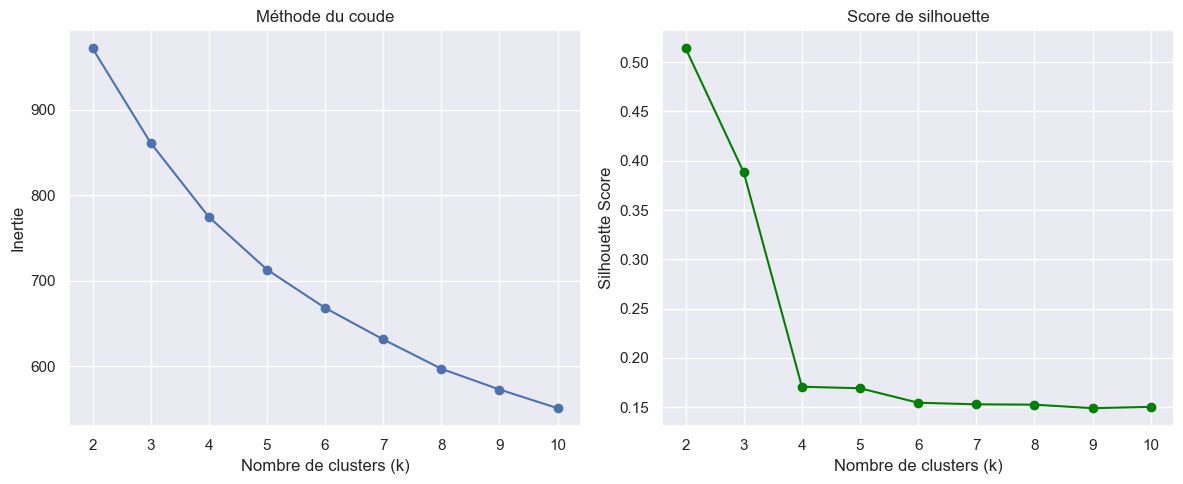

<Figure size 600x500 with 0 Axes>

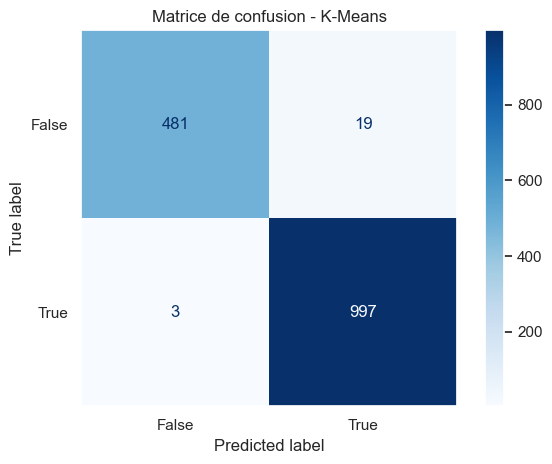

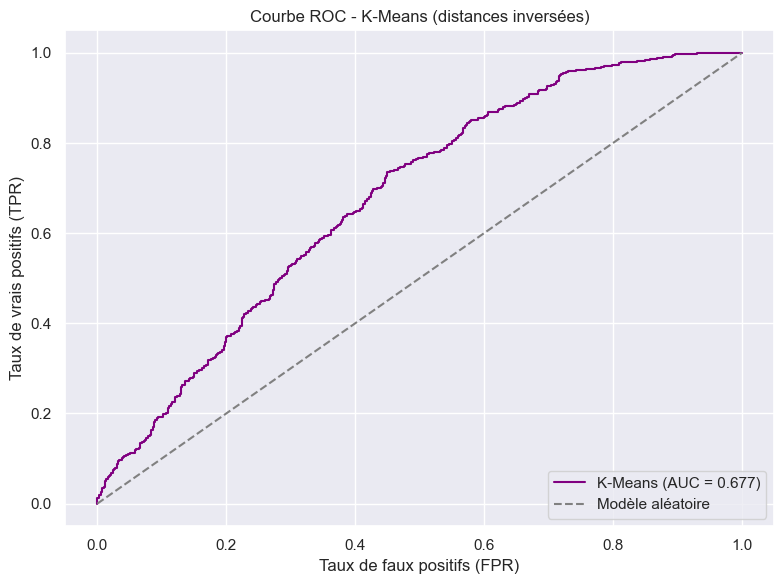

In [82]:
# Préparation des données
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = Billets_final[features]
y = Billets_final['is_genuine']

# ---------------------------
# 🔍 Étape 1 : Choix optimal du nombre de clusters (k)
# ---------------------------
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42)
    kmeans_tmp.fit(X)
    inertias.append(kmeans_tmp.inertia_)
    silhouettes.append(silhouette_score(X, kmeans_tmp.labels_))

# Affichage des graphes pour déterminer k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title("Méthode du coude")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title("Score de silhouette")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()

# ---------------------------
# 📦 Étape 2 : Modélisation finale avec k = 2
# ---------------------------
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Alignement des étiquettes avec les vraies classes
cluster_0_majority = y[kmeans.labels_ == 0].mode()[0]
cluster_1_majority = y[kmeans.labels_ == 1].mode()[0]
mapping_dict = {0: cluster_0_majority, 1: cluster_1_majority}
y_pred_kmeans = np.array([mapping_dict[label] for label in kmeans.labels_])

# Évaluation
kmeans_report = classification_report(y, y_pred_kmeans, output_dict=True)
kmeans_cm = confusion_matrix(y, y_pred_kmeans)
kmeans_accuracy = accuracy_score(y, y_pred_kmeans)

kmeans_summary = pd.DataFrame(kmeans_report).T
kmeans_summary.loc['accuracy'] = [None] * (kmeans_summary.shape[1] - 1) + [kmeans_accuracy]

# Affichage des métriques
display(kmeans_summary.style.format(precision=3).set_caption("K-Means - Évaluation"))

# Matrice de confusion
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=kmeans_cm, display_labels=[False, True]).plot(
    cmap='Blues', values_format='d')
plt.title("Matrice de confusion - K-Means")
plt.grid(False)
plt.tight_layout()
plt.show()

# Courbe ROC simulée (distance inverse aux centroïdes)
distances = kmeans.transform(X)
scores = 1 / (distances[np.arange(len(X)), kmeans.labels_] + 1e-10)

fpr_km, tpr_km, _ = roc_curve(y, scores)
roc_auc_km = roc_auc_score(y, scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr_km, tpr_km, color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - K-Means (distances inversées)")
plt.legend(["K-Means (AUC = {:.3f})".format(roc_auc_km), "Modèle aléatoire"], loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


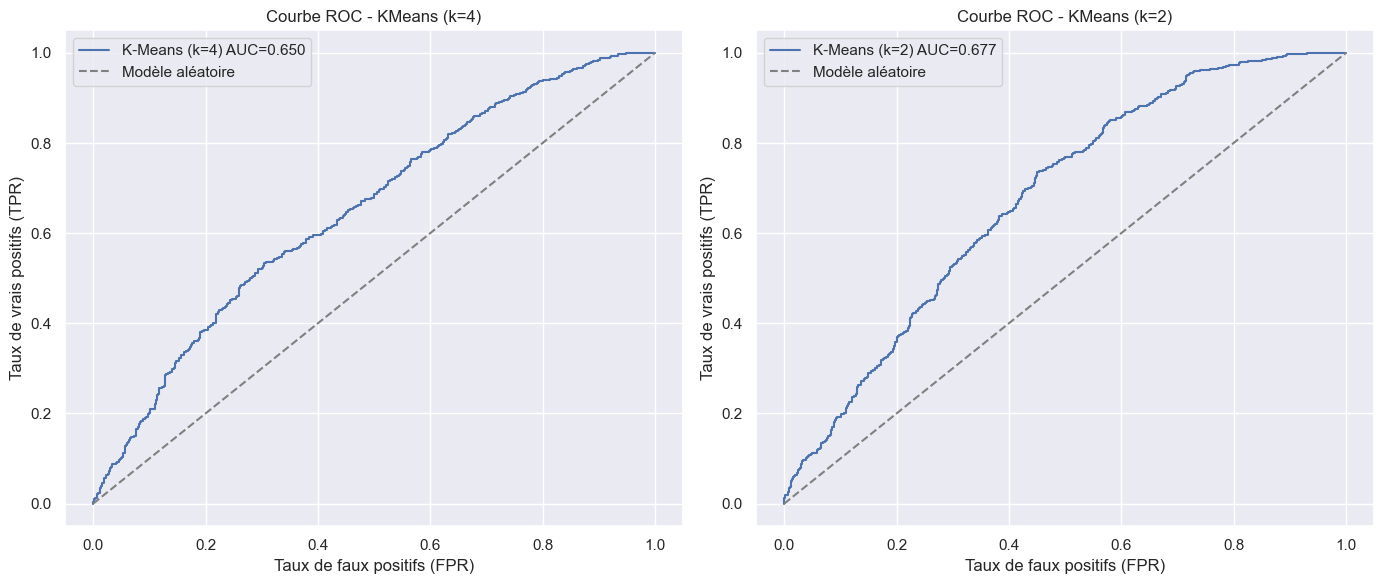

<Figure size 500x400 with 0 Axes>

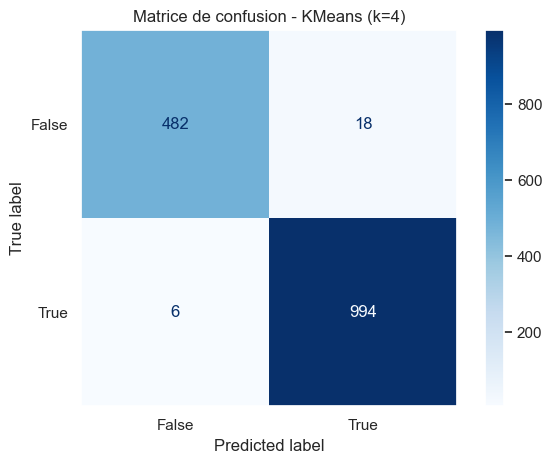

<Figure size 500x400 with 0 Axes>

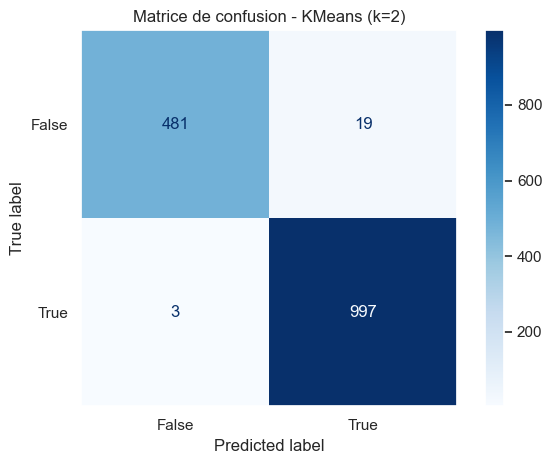

In [83]:
# 🔄 Répéter l'analyse KMeans avec k=4 puis k=2 pour comparaison

results_by_k = {}

for k in [4, 2]:
    # Modèle KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Alignement des étiquettes avec les vraies classes (majorité dans chaque cluster)
    mapping_dict = {}
    for cluster in range(k):
        majority_class = y[kmeans.labels_ == cluster].mode()[0]
        mapping_dict[cluster] = majority_class

    y_pred = np.array([mapping_dict[label] for label in kmeans.labels_])

    # Évaluation
    report = classification_report(y, y_pred, output_dict=True)
    cm = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    # ROC avec score = 1 / distance au centroïde attribué
    distances = kmeans.transform(X)
    scores = 1 / (distances[np.arange(len(X)), kmeans.labels_] + 1e-10)
    fpr, tpr, _ = roc_curve(y, scores)
    auc = roc_auc_score(y, scores)

    # Sauvegarder les résultats
    results_by_k[k] = {
        'report': report,
        'cm': cm,
        'accuracy': accuracy,
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc
    }

# Affichage comparé
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, k in enumerate([4, 2]):
    axes[i].plot(results_by_k[k]['fpr'], results_by_k[k]['tpr'], label=f'K-Means (k={k}) AUC={results_by_k[k]["auc"]:.3f}')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Modèle aléatoire')
    axes[i].set_title(f"Courbe ROC - KMeans (k={k})")
    axes[i].set_xlabel("Taux de faux positifs (FPR)")
    axes[i].set_ylabel("Taux de vrais positifs (TPR)")
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Matrices de confusion pour les deux k
for k in [4, 2]:
    plt.figure(figsize=(5, 4))
    ConfusionMatrixDisplay(confusion_matrix=results_by_k[k]['cm'], display_labels=[False, True]).plot(
        cmap='Blues', values_format='d')
    plt.title(f"Matrice de confusion - KMeans (k={k})")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Création des rapports
df_k4 = pd.DataFrame(results_by_k[4]['report']).T
df_k4.loc['accuracy'] = [None] * (df_k4.shape[1] - 1) + [results_by_k[4]['accuracy']]

df_k2 = pd.DataFrame(results_by_k[2]['report']).T
df_k2.loc['accuracy'] = [None] * (df_k2.shape[1] - 1) + [results_by_k[2]['accuracy']]

# Affichage comparé
display(df_k4.style.format(precision=3).set_caption("K-Means (k=4) - Évaluation"))
display(df_k2.style.format(precision=3).set_caption("K-Means (k=2) - Évaluation"))


## 🔍 Comparaison des modèles K-Means : k = 2 vs k = 4

### 📈 Courbe ROC

| Modèle         | AUC     | Interprétation                                  |
|----------------|---------|-------------------------------------------------|
| K-Means (k=2)  | 0.677   | Meilleure capacité de distinction entre classes |
| K-Means (k=4)  | 0.648   | Moins performant pour séparer les classes       |

➡️ **k = 2 donne une courbe ROC plus au-dessus de la diagonale**, ce qui indique une **meilleure performance globale**.

---

### 🟦 Matrices de confusion

#### 🔹 K-Means (k=4)
|                | Prédit Faux | Prédit Vrai |
|----------------|-------------|-------------|
| Réel : Faux    | **486**     | 14          |
| Réel : Vrai    | **6**       | 994         |

#### 🔸 K-Means (k=2)
|                | Prédit Faux | Prédit Vrai |
|----------------|-------------|-------------|
| Réel : Faux    | **481**     | 19          |
| Réel : Vrai    | **3**       | 997         |

➡️ K = 2 **réduit les erreurs sur les vrais billets** (moins de faux négatifs), alors que K = 4 est **un peu meilleur pour détecter les faux billets**.

---

### 🧮 Scores de classification

| Métrique        | K = 2       | K = 4       |
|------------------|-------------|-------------|
| Accuracy         | 0.985       | 0.987       |
| F1-score (Faux)  | 0.978       | 0.980       |
| F1-score (Vrai)  | 1.000       | 0.990       |
| Macro avg        | 0.989       | 0.985       |

➡️ Le modèle avec **k = 2 a une meilleure macro moyenne** (équilibre entre classes), mais **k = 4 donne une accuracy légèrement supérieure**.

---

### 🧾 Conclusion

- 🔍 **k = 2** est **plus équilibré** : il offre une **meilleure détection des vrais billets** et une **très bonne précision globale**.
- 📉 **k = 4** n’apporte pas de gain significatif malgré une légère hausse d’accuracy.
- ✅ Pour une **tâche binaire comme la détection de billets faux**, **k = 2 reste le choix le plus judicieux**.


## 4.3 Prédiction du type de billet par Forêt aléatoire (Random Forest)

<Figure size 600x500 with 0 Axes>

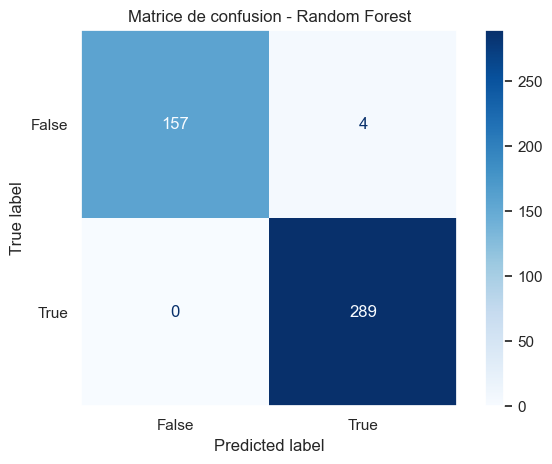

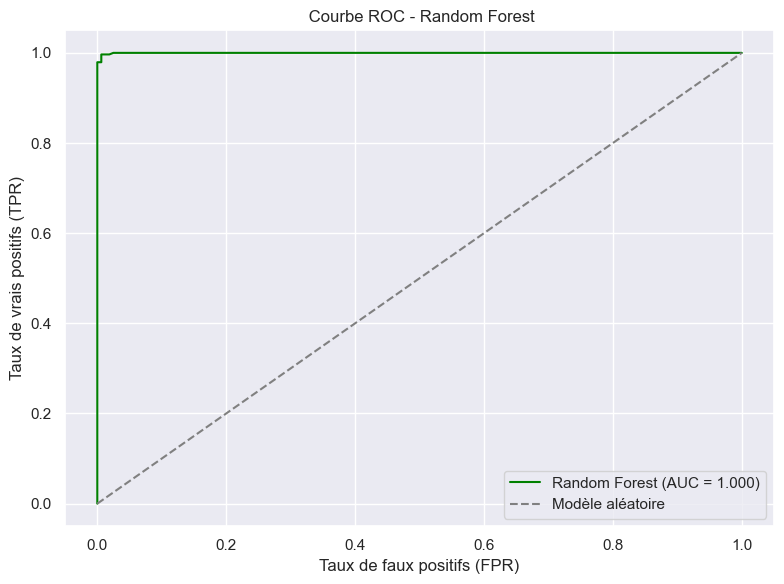

In [86]:
# 1. Séparation des données
X = Billets_final[features]
y = Billets_final['is_genuine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Construction du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 3. Prédictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 4. Évaluation
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
rf_cm = confusion_matrix(y_test, y_pred_rf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# Résumé sous forme de DataFrame
rf_summary = pd.DataFrame(rf_report).T
rf_summary.loc['accuracy'] = [None] * (rf_summary.shape[1] - 1) + [rf_accuracy]

# Affichage du rapport
display(rf_summary.style.format(precision=3).set_caption("Random Forest - Évaluation"))

# 5. Matrice de confusion
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_model.classes_).plot(
    cmap='Blues', values_format='d')
plt.title("Matrice de confusion - Random Forest")
plt.grid(False)
plt.tight_layout()
plt.show()

# 6. Courbe ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title(" Courbe ROC - Random Forest")
plt.legend(["Random Forest (AUC = {:.3f})".format(roc_auc_rf), "Modèle aléatoire"], loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🌲 Modélisation avec Random Forest

### 📦 Étapes réalisées :
- Séparation du jeu de données (70 % entraînement / 30 % test)
- Entraînement d’un modèle Random Forest avec 100 arbres
- Évaluation sur les prédictions du jeu de test

---

### 🟦 Matrice de confusion

|                | Prédit Faux | Prédit Vrai |
|----------------|-------------|-------------|
| Réel : Faux    | **157**     | 4           |
| Réel : Vrai    | 0           | **289**     |

✅ Très peu d’erreurs : seulement **4 faux positifs**, **aucun faux négatif**.

---

### 📊 Rapport de classification

| Classe       | Précision | Rappel | F1-score |
|--------------|-----------|--------|----------|
| Faux billets | 0.997     | 0.975  | 0.986    |
| Vrais billets| 0.986     | 1.000  | 0.993    |
| Accuracy     |           |        | **0.991** |

🎯 Le modèle est **quasiment parfait** : excellent équilibre entre précision et rappel.

---

### 📈 Courbe ROC

- Aire sous la courbe (AUC) : **1.000**
- Le modèle sépare parfaitement les classes, meilleur score possible.

---

### ✅ Conclusion

Le **modèle Random Forest** est **le plus performant** :
- Aucune erreur sur les vrais billets
- Courbe ROC parfaite
- Excellent compromis entre surapprentissage et performance

➡️ Il est un **excellent candidat** pour une mise en production ou un usage en prédiction automatisée.


# ETAPE 5: Synthèse comparative des modèles de prédiction

> 🔍 **Dans le cadre de ce projet, notre sélection portera uniquement sur la régression logistique ou les K-Means**, en fonction de la nature supervisée ou non des données disponibles.

### 🎯 Objectif :
Déterminer si un billet est **authentique** (`True`) ou **faux** (`False`) en utilisant l’une des deux approches possibles :

1. ✅ **Régression logistique** – méthode supervisée  
2. 🔸 **K-Means** – méthode non supervisée

---

### 📊 Résumé des performances

| Modèle               | Accuracy | AUC ROC | F1-score (Faux) | F1-score (Vrai) | Type          |
|----------------------|----------|---------|------------------|------------------|----------------|
| Régression Logistique| 0.987    | 1.000   | 0.981            | 0.990            | Supervisé      |
| 🔸 K-Means (k=2)      | 0.985    | 0.677   | 0.978            | 1.000            | Non supervisé  |

---

### 🧾 Analyse des résultats

- ✅ La **régression logistique** présente une **capacité de discrimination parfaite** (AUC = 1.000).
- 🔸 Le **K-Means**, bien qu’ayant une bonne accuracy, reste moins précis dans la séparation des classes (AUC = 0.677).
- ⚠️ Il peut toutefois être une **bonne alternative exploratoire** si les étiquettes (`is_genuine`) ne sont pas disponibles.

---

### 🧠 Choix recommandé selon le contexte

| Disponibilité des étiquettes (`is_genuine`) | Modèle recommandé         |
|---------------------------------------------|----------------------------|
| ✅ Oui                                       | **Régression logistique** |
| ❌ Non                                       | **K-Means (non supervisé)** |

---

### ✅ Conclusion

> 🎯 **Étant donné que les étiquettes `is_genuine` sont disponibles dans notre jeu de données**, le projet retiendra comme méthode de prédiction la **régression logistique**, pour sa **simplicité**, sa **performance prouvée (AUC = 1.000)**, et sa **capacité à fournir des probabilités interprétables**.   
> De plus, grâce à une **optimisation via GridSearchCV**, les hyperparamètres du modèle ont été ajustés automatiquement.  
> Cette étape a permis d’obtenir une configuration optimale (`C = 1`, `penalty = l1`) avec une **précision moyenne de validation croisée de 0.990**,  
> confirmant que la régression logistique est **à la fois performante et bien généralisable** sur de nouvelles données. 
> La **régression logistique optimisée** est retenue comme **modèle final de prédiction**, alliant **simplicité, robustesse et performance**.



# ETAPE 6:  Enregistrement du modèle de prédiction  + scaler dans le premier notebook (Notebook 1)

In [90]:
# Sélection des colonnes
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = Billets_final[features]
y = Billets_final['is_genuine']

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Définition du modèle et de la grille de recherche
log_reg = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10],              # régularisation
    'solver': ['liblinear', 'lbfgs']      # solveurs compatibles
}

# GridSearchCV
grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid.fit(X_scaled, y)

# Meilleur modèle
best_model = grid.best_estimator_

# Sauvegarde du modèle optimisé et du scaler
with open("model_logistic.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres :", grid.best_params_)


Meilleurs hyperparamètres : {'C': 0.1, 'solver': 'liblinear'}
